# Week 0 - Introduction: Fitting a line to data

We are going to start with a simple, straight-forward example often encountered in astronomy: how to fit a line to data. Specifically, we have a set of data $(x, y)$, and we would like to find the best $(m,b)$ such that: 

$$y = mx+b$$

The classical approach to this problem uses a least-squares algorithm, which uses linear algebra. First, we construct our vectors and matrices:

$$
X = \begin{bmatrix}
b \\
m
\end{bmatrix}
$$

$$ Y = \left[ 
             \begin{matrix} 
                y_1 \\
                y_2 \\
                \vdots \\
                y_N
             \end{matrix}
    \right] 
$$

$$ A = 
    \begin{bmatrix} 
        1 & x_1 \\
        1 & x_2 \\
        \vdots & \vdots \\
        1 & x_N
    \end{bmatrix}
$$

$$ C = 
    \begin{bmatrix} 
        \sigma^2_{y_1} & 0 & \dots & 0 \\
        0 & \sigma^2_{y_2} & \dots & 0 \\
        \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & \dots & \sigma^2_{y_N}
    \end{bmatrix}
$$

Using linear algebra we can construct the matrix formula:

$$
Y = A X
$$

Take a second to make sure this makes sense with the definitions of the above vectors and matrices. It should quickly become obvious that there is a problem with the above equation: the problem is over-constrained, and nowhere have we taken into account uncertainties on the measurements. This is where the linear algebra becomes helpful. 

$$
\delta = Y - A X
$$
Here, $\delta$ is the difference between $Y$ and $A X$. We want to weight each data point by the inverse of its uncertainty then reduce dimensionality into a scalar quantity. We call this quantity $\chi^2$:
$$
\chi^2 = \sum_{i=1}^N \frac{\left[ y_i - f(x_i) \right]^2}{\sigma^2_{y,i}} \equiv \left[ Y - A X \right]^T C^{-1} \left[ Y - A X \right]
$$

Our goal is to minimize $\chi^2$. To get this, we first left multiply both sides of our equation $Y = A X$ by $C^{-1}$ (the inverse of the covariance matrix), which serves to weight each individual data point by its uncertainty. If you think about, this makes sense since smaller uncertainties (smaller values of $\sigma_{y_i}$) should be weighted stronger. Our matrix equation now becomes:

$$
C^{-1} Y = C^{-1} A X
$$

We are almost there. If you look at the dimensionality of the matrices on each side, you'll see that each side is equal to a vector of length $N$. To reduce the dimensionality, we now left-multiply each side by $A^T$. You can convince yourself that this reduces each side to a vector of length 2:

$$
A^T C^{-1} Y = A^T C^{-1} A X
$$

As a last step, we want to solve for $X$, so we left-multiply each side by $\left[ A^T C^{-1} A \right]^{-1}$ obtaining the simple result:

$$ X =
\left[ A^T C^{-1} A \right]^{-1} \left[ A^T C^{-1} Y \right]
$$

It should be clear that, once the matrices $Y$, $A$, and $C$ are defined, this is an extremely easy matrix equation to solve with standard matrix libraries.

Let's put this into practice with a simple code example.

In [42]:
# Load libraries

import numpy as np
from numpy.linalg import inv
from astropy.table import Table
import matplotlib.pyplot as plt

%matplotlib inline

### Let's take some data from the literature for RR Lyrae stars in M4

RR Lyrae stars are variable pulsators that obey a precise period-luminosity relation. As such they are used as a distance indicator. Here we will attempt to determine the distance to the globular cluster M4 using a sample of 37 RR Lyrae stars observed with Spitzer by Neeley et al. (2015): http://cdsads.u-strasbg.fr/abs/2015ApJ...808...11N

The FU class of RR Lyrae follow the relation:

$$
m = m\ ({\rm log}\ P + 0.26) + b
$$

In [148]:
# First we use astropy tables to load the data, which we obtained directly from CDS

readme = '../data/Week_0/ReadMe'
RR_lyrae_table2 = Table.read('../data/Week_0/table2.dat', readme=readme, format='cds')

# Remove Blazhko candidates from RR Lyrae sample 
# Blazhko = RR_lyrae_table2[np.where(RR_lyrae['f_Mode'] == '*')[0]]
# RR_lyrae = RR_lyrae_table2[np.where(RR_lyrae['f_Mode'] != '*')[0]]
# We will select just the 'FU' type RR Lyraes
RR_lyrae = RR_lyrae_table2[np.where(RR_lyrae_table2['Mode'] == 'RRab')]

# Now remove sources V20 and V21 due to blending
RR_lyrae = RR_lyrae[np.where(RR_lyrae['ID'] != 'V20')[0]]
RR_lyrae = RR_lyrae[np.where(RR_lyrae['ID'] != 'V21')[0]]
print RR_lyrae.colnames

['ID', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'Per', 'logP', '[3.6]', 'e_[3.6]', 'f_[3.6]', '[4.5]', 'e_[4.5]', 'f_[4.5]', '3.6amp', 'e_3.6amp', '4.5amp', 'e_4.5amp', 'Mode', 'f_Mode']


### Now, let's define our matrices as we did above to calculate the best fit line

In [149]:
def calc_best_fit(data_x, data_y, data_y_err):

    Y = np.matrix(data_y).T                         # The y-values
    N = Y.size                                      # The number of observations

    A = np.ones((N, 2))                             # Create a 2xN matrix of 1's
    A[:,1] = data_x + 0.26                                # Set the second row to the x-values
    A = np.matrix(A)                                # Convert numpy array to a numpy matrix

    C = np.identity(N) * data_y_err                 # Create the covariance matrix
    C = np.matrix(C)                                # Convert numpy array to a numpy matrix

    X = inv(A.T * inv(C) * A) * (A.T * inv(C) * Y)  # Our solution vector
    return np.array(X)                              # Convert back from numpy matrix to numpy array

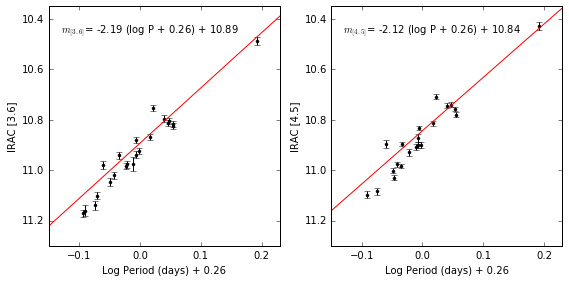

In [180]:
def plot_line(ax, b, m, mag):
    x = ax.get_xlim()
    y = m*x + b
    
    ax.plot(x, y, color='r')
    ax.text(-0.13, 10.45, mag + '= ' + str(np.around(m[0], decimals=2)) + ' (log P + 0.26) + ' + str(np.around(b[0], decimals=2)))
    

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].errorbar(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], yerr=RR_lyrae['e_[3.6]'], fmt='o', marker='.', color='k')
ax[1].errorbar(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], yerr=RR_lyrae['e_[4.5]'], fmt='o', marker='.', color='k')

for i in np.arange(2):
    ax[i].set_ylim(11.3, 10.35)
    ax[i].set_xlim(-0.15, 0.23)
    ax[i].set_xticks([-0.1, 0.0, 0.1, 0.2])


b, m = calc_best_fit(RR_lyrae['logP'], RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]'])
plot_line(ax[0], b, m, r'$m_{[3.6]}$')

b, m = calc_best_fit(RR_lyrae['logP'], RR_lyrae['[4.5]'], RR_lyrae['e_[4.5]'])
plot_line(ax[1], b, m, r'$m_{[4.5]}$')



ax[0].set_xlabel('Log Period (days) + 0.26')
ax[1].set_xlabel('Log Period (days) + 0.26')

ax[0].set_ylabel('IRAC [3.6]')
ax[1].set_ylabel('IRAC [4.5]')




plt.tight_layout()
plt.show()

Now, we will keep the slope we have just derived, but use five Galactic RR Lyrae to calibrate the zero point of the period-luminosity relation. From these, we get the following relations:

$$
M_{[3.6]} = -2.19\ {\rm log}\ P - 1.176
$$

$$
M_{[4.5]} = -2.12\ {\rm log}\ P - 1.199
$$

Comparing these relations to our observed relations, we get:

$$
m_{[3.6]} = -2.19\ ({\rm log}\ P + 0.26) + 10.89
$$

$$
m_{[4.5]} = -2.12\ ({\rm log}\ P + 0.26) + 10.84
$$

Subtracting the two, we get two measurements for a distance modulus:

$$
\mu_{[3.6]} = \left( m_{[3.6]} - M_{[3.6]} \right) = 11.497
$$

$$
\mu_{[4.5]} = \left( m_{[4.5]} - M_{[4.5]} \right) = 11.488
$$

This modulus implies a distance:

$$
D = 1993\ {\rm pc}: \lambda\ =\ 3.6\ \mu {\rm m}
$$

$$
D = 1984\ {\rm pc}: \lambda\ =\ 4.5\ \mu {\rm m}
$$

Uncertainties are given by:
    

$$
\begin{bmatrix}
\sigma_b^2 & \sigma_{m,b} \\
\sigma_{m,b} & \sigma_m^2
\end{bmatrix} =
\begin{bmatrix}
A^T C^{-1} A
\end{bmatrix}^{-1}
$$

This method has several benefits:

1. Non-parametric method

2. Uses standard linear algebra techniques

3. Can be abstracted to higher order polynomials



But, this is a somewhat specialized situation. The above equation for $X$ has three assumptions built-in:

1. Uncertainties are Gaussian

2. Uncertainties only on the y-axis

3. Can't add lower or upper limits